# Introduction
- Please see d213-illovsky-task1-pa-submission.docx for the written report. This the code and the calculations and output.
- Part IV, Section E: **Data Summary and Implications, is duplicated from the Word Document**.
# Part I: Research Question
## A1: Research Question
- The research question for this paper aims to address is: Can ARIMA time series modeling forecast the next month of revenue from the previous two years of daily revenue of a health care organization?
## A2: Objectives or Goals
- The goal of this analysis is to develop an ARIMA time series model to forecast the next month of revenue for a healthcare organization from the past two years of previous daily revenue data.


# Code, Calculations, Output for Parts II - IV

## Load Libraries and Data

In [115]:
# import datetime for manipulating dates and times
import datetime
# math functions
from math import sqrt
# enable inline backend. should be before importing matplotlib
%matplotlib inline 
# import matplot lib for 2D visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #D1A
from matplotlib.pyplot import figure
import numpy as np # work with arrays and mathmatical operations
import os # interfacing with the operating system
import pandas as pd # work with dataframe. can think of as python's excel fxnality
# also gives seasonality, which spectral density provides
from pmdarima import auto_arima
# spectral density
from scipy import signal
from sklearn.metrics import mean_squared_error
# Import seaborn for creating more advanced statistical visualizations
import seaborn as sns
# autocorrelation. acf. pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
# ARIMA D2
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# decompose seasonality (D1)
from statsmodels.tsa.seasonal import seasonal_decompose
# import statsmodels for adfuller. test for stationarity
from statsmodels.tsa.stattools import adfuller, kpss
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [81]:
directory_path = os.getcwd()
print("My current directory is : " + directory_path)
df=pd.read_csv('../medical-dataset/medical_time_series.csv') # can set the index, in the read_csv method.
# df=df.dropna()
print('Shape of data:', df.shape)

My current directory is : c:\Users\pinlo\OneDrive\Desktop\WGU\d213-wgu\submissions
Shape of data: (731, 2)


In [82]:
pd.set_option('display.max_rows', 100) # set the maximum number of rows to 100
pd.set_option('display.max_columns', None) # set the maximum number of columns to None (no limit)
pd.set_option('display.width', None) # set the width of the display to None (auto-detect)

df.head()

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


## EDA - Examine Data

In [83]:
print(f"Dimensions{df.shape}")
print(df.describe())
df.info()

Dimensions(731, 2)
              Day     Revenue
count  731.000000  731.000000
mean   366.000000   14.179608
std    211.165812    6.959905
min      1.000000   -4.423299
25%    183.500000   11.121742
50%    366.000000   15.951830
75%    548.500000   19.293506
max    731.000000   24.792249
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


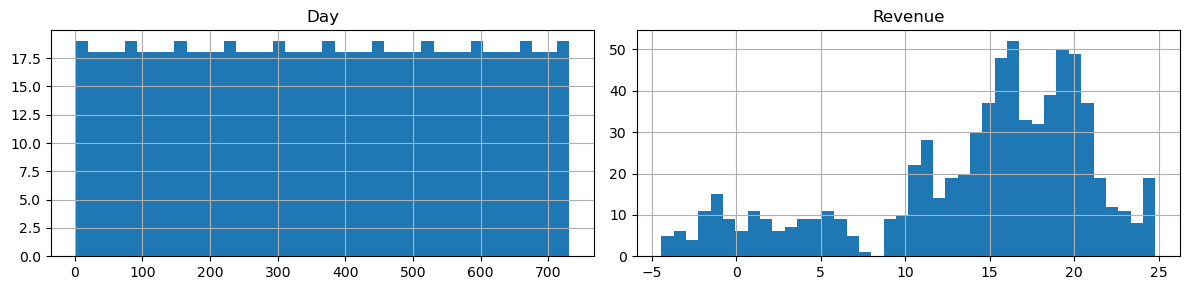

In [84]:
# Histograms
df.hist(figsize=(12, 3),bins=40)
plt.tight_layout()
plt.show()

In [85]:
# Evaluate the dataset for missing values and duplicate rows
print(df.isnull().sum())
print(df.duplicated().sum())

Day        0
Revenue    0
dtype: int64
0


## C1. Provide line graph visualization

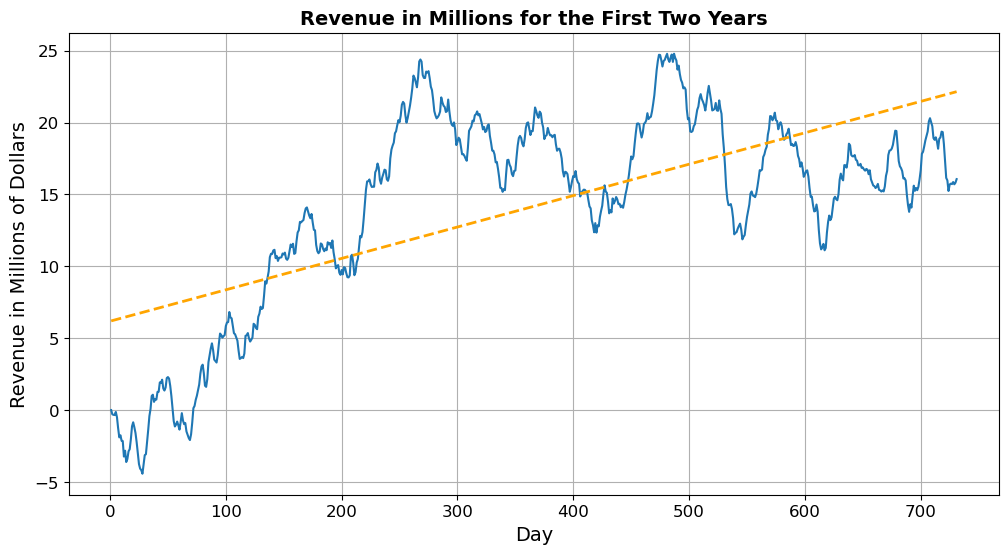

In [86]:
plt.figure(figsize=(12,6))
# Plot the revenue data using a line chart
plt.plot(df['Day'], df['Revenue'])
# Set the title of the plot
plt.title("Revenue in Millions for the First Two Years", fontsize=14, fontweight="bold")
# Set the x-axis label
plt.xlabel('Day', fontsize=14)
# Set the y-axis label
plt.ylabel("Revenue in Millions of Dollars", fontsize=14)
# Enable the grid on the plot
plt.grid()
# Set the x-axis interval to 100
plt.xticks(np.arange(0, max(df['Day'])+100, 100))
# Set the font size of the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Calculate the linear trend line
z = np.polyfit(df['Day'], df['Revenue'], 1)
p = np.poly1d(z)
# Plot the trend line
# https://www.statology.org/matplotlib-trendline/
plt.plot(df['Day'], p(df['Day']), color="orange", linewidth=2, linestyle="--")
# Show the plot
plt.show()

## C2 - Time Series Formatting

### Check for gaps

In [87]:
try:
    assert df['Day'].nunique() == len(df)
    print("The number of unique days is equal to the length of the DataFrame.")
except AssertionError:
    print("The number of unique days is not equal to the length of the DataFrame.")

The number of unique days is equal to the length of the DataFrame.


### Transform Day to datetime Format
#### Set Day as Index

In [90]:
# Convert the column Day to a time series format
df['Day'] = pd.date_range(start=datetime.datetime(1970, 1, 1),
                        periods=df.shape[0], freq='24H')
# Set the Day as an index
df.set_index('Day', inplace=True)

### Plots of cleaned data

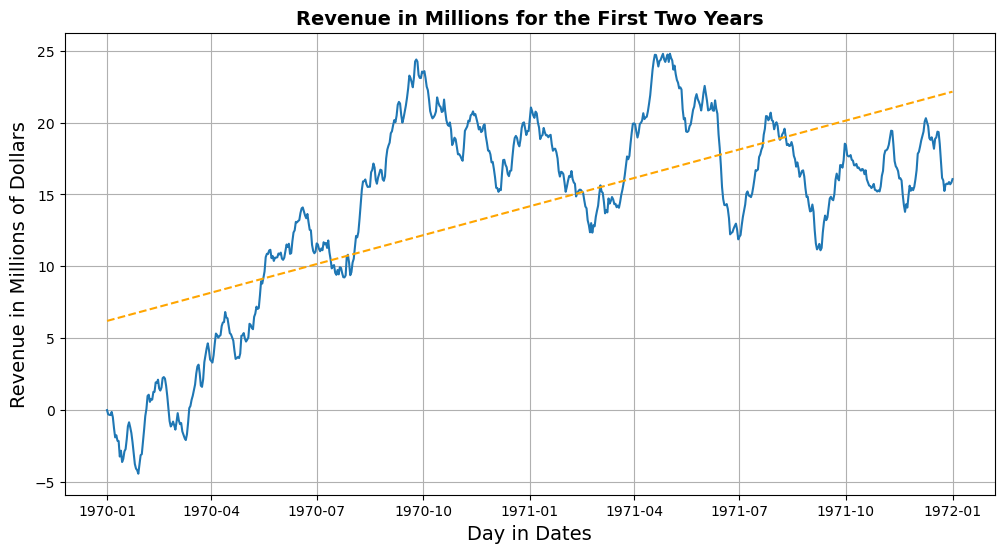

In [93]:
# Explore the data by Visualizing the data.
plt.figure(figsize= (12 ,6))
plt.plot(df.Revenue)
# Set the title of the plot
plt.title("Revenue in Millions for the First Two Years", fontsize=14, fontweight="bold")
plt.xlabel('Day in Dates', fontsize=14)
plt.ylabel('Revenue in Millions of Dollars', fontsize=14)
plt.grid(True)

# Calculate the coefficients of a linear trend line
z = np.polyfit(np.arange(len(df)), df['Revenue'], 1)

# Create a polynomial object
p = np.poly1d(z)

# Add trendline to plot
plt.plot(np.arange(len(df)), p(np.arange(len(df))), 'r--', color='orange')

# Show the plot
plt.show()


In [94]:
df.head()
df.describe()

,Revenue
count,731.000000
mean,14.179608
std,6.959905
min,-4.423299
25%,11.121742
50%,15.951830
75%,19.293506
max,24.792249


## C3 Evaluate the stationarity

### Rolling Mean and Standard Deviation

              Revenue
Day                  
1970-01-01        NaN
1970-01-02        NaN
1970-01-03        NaN
1970-01-04        NaN
1970-01-05        NaN
...               ...
1971-12-28  17.246163
1971-12-29  16.995334
1971-12-30  16.723707
1971-12-31  16.427933
1972-01-01  16.155528

[731 rows x 1 columns]              Revenue
Day                 
1970-01-01       NaN
1970-01-02       NaN
1970-01-03       NaN
1970-01-04       NaN
1970-01-05       NaN
...              ...
1971-12-28  1.648115
1971-12-29  1.606064
1971-12-30  1.515067
1971-12-31  1.279104
1972-01-01  0.892651

[731 rows x 1 columns]


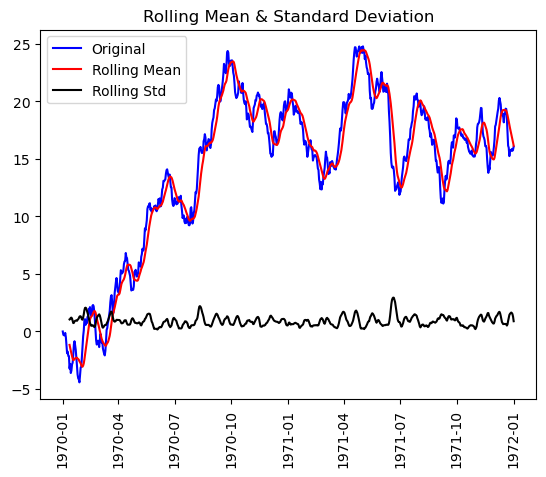

In [95]:
# Indexed df
rolmean = df.rolling(window=12).mean() # Monthly level
rolstd = df.rolling(window=12).std()
print (rolmean, rolstd)

orig = plt.plot(df, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
# Rotate x-axis labels
plt.xticks(rotation=90)
plt.show(block=False)

### Augmented Dickey-Fuller Test

In [96]:
df_test = adfuller(df['Revenue'], autolag='AIC')
dfoutput = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used', 'No. Observations'])
for key,value in df_test[4].items():
	dfoutput['Critical Value (%s) '%key] = value
print(dfoutput)
# add our NULL Hypothesis
if df_test[1] <= 0.05:
    print("Reject null hypothesis, the time series is stationary")
else:
    print("Fail to reject null hypothesis, the time series is non-stationary")
# Dr. Sewell says a good sign is for the critical values to be less than the test statistic aka ADF

Test Statistic            -2.218319
p-value                    0.199664
#Lags Used                 1.000000
No. Observations         729.000000
Critical Value (1%)       -3.439352
Critical Value (5%)       -2.865513
Critical Value (10%)      -2.568886
dtype: float64
Fail to reject null hypothesis, the time series is non-stationary


### Transform to Stationary

In [97]:
# difference the data
df_stationary = df.diff().dropna()
df_stationary

,Revenue
Day,
1970-01-02,-0.292356
1970-01-03,-0.035416
1970-01-04,-0.012215
1970-01-05,0.215100
1970-01-06,-0.366702
...,...
1971-12-28,-0.032693
1971-12-29,0.143766
1971-12-30,-0.156834


### Evaluate Stationarity again
Results: Data was made stationary with one diff ('D' in PDQ)

In [98]:
df_test = adfuller(df_stationary['Revenue'], autolag='AIC')
dfoutput = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used', 'No. Observations'])
for key,value in df_test[4].items():
	dfoutput['Critical Value (%s) '%key] = value
print(dfoutput)
# add our NULL Hypothesis
if df_test[1] <= 0.05:
    print("Reject null hypothesis, the time series is stationary")
else:
    print("Fail to reject null hypothesis, the time series is non-stationary")

Test Statistic          -1.737477e+01
p-value                  5.113207e-30
#Lags Used               0.000000e+00
No. Observations         7.290000e+02
Critical Value (1%)     -3.439352e+00
Critical Value (5%)     -2.865513e+00
Critical Value (10%)    -2.568886e+00
dtype: float64
Reject null hypothesis, the time series is stationary


### Split the Data

In [99]:
# 730 x .8 for eighty percent
print(730*.8)
print(730*.2)

584.0
146.0


In [100]:
#Split data into train(80%) and test (20%).

df_train = df.iloc[:585]
df_test = df.iloc[585:]
print(len(df_train)+len(df_test))
print(df_train.shape, df_test.shape)

731
(585, 1) (146, 1)


In [101]:
df_test.tail()

,Revenue
Day,
1971-12-28,15.722056
1971-12-29,15.865822
1971-12-30,15.708988
1971-12-31,15.822867
1972-01-01,16.069429


## C5 Cleaned dataset

In [102]:
df_stationary.to_csv('../submissions/d213_illovsky_task1_clean.csv')
df_train.to_csv('../submissions/d213_illovsky_task1_train.csv')
df_test.to_csv('../submissions/d213_illovsky_task1_test.csv')

## D1. Findings and Visualizations
## D1A. Seasonality 

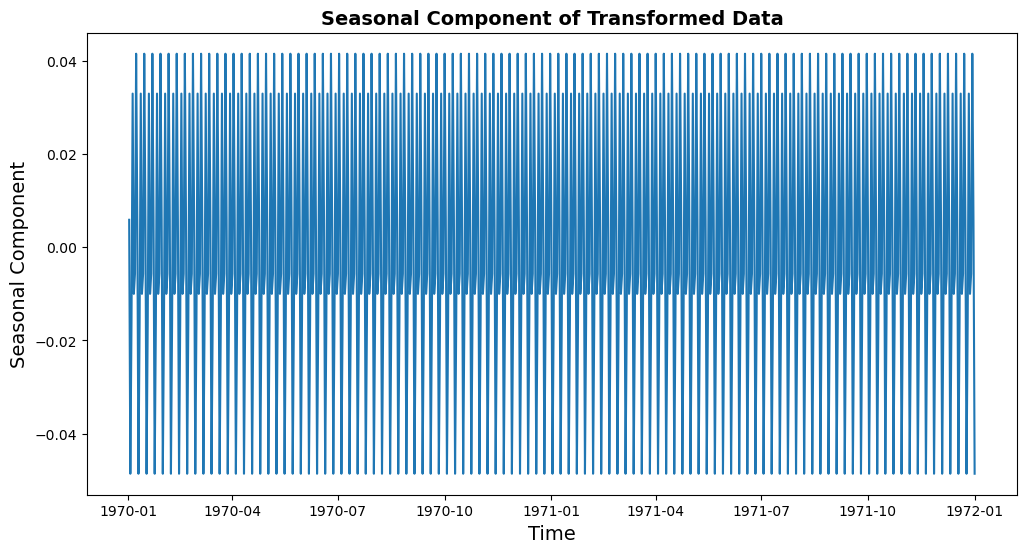

In [103]:
# Seasonal Decompose Treated and Transformed Data
df_decomposed = seasonal_decompose(df_stationary)
# Create a figure
plt.figure(figsize= [12, 6])
# Plot the seasonal component
plt.plot(df_decomposed.seasonal)
# Add a title and axis labels
plt.title("Seasonal Component of Transformed Data", fontsize=14, fontweight="bold")
plt.xlabel("Time", fontsize=14, fontweight="normal", color="black")
plt.ylabel("Seasonal Component", fontsize=14, fontweight="normal", color="black")
# Show the plot
plt.show()


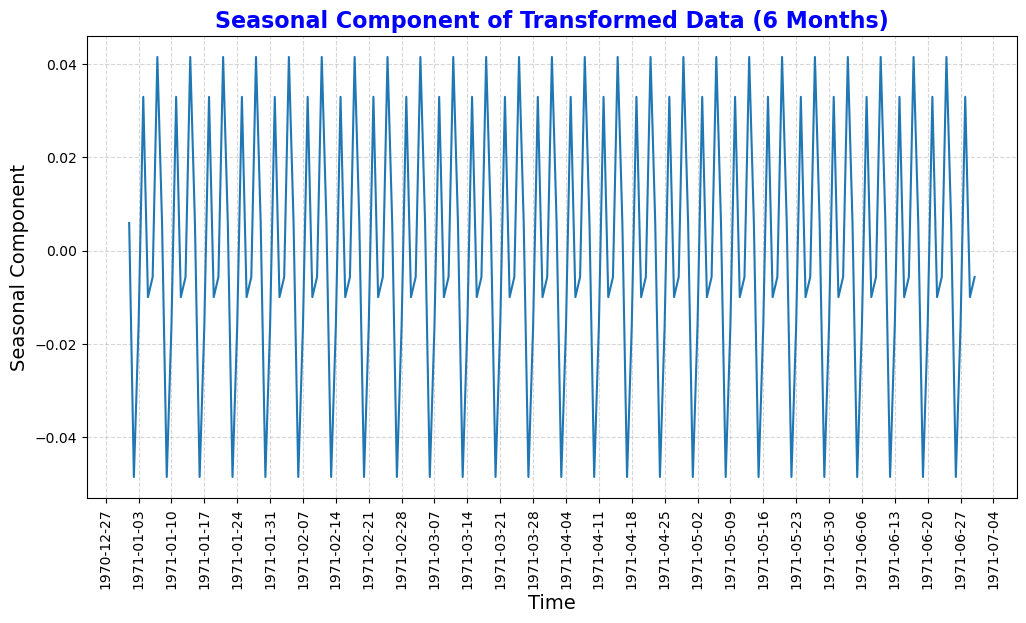

In [104]:
# Slice the dataframe for the desired period
df_period = df_decomposed.seasonal['1971-01-01':'1971-06-30']

# Create a figure
plt.figure(figsize= [12, 6])

# Plot the seasonal component
plt.plot(df_period)

# Add a title and axis labels
plt.title("Seasonal Component of Transformed Data (6 Months)", fontsize=16, fontweight="bold", color="blue")
plt.xlabel("Time", fontsize=14, fontweight="normal", color="black")
plt.ylabel("Seasonal Component", fontsize=14, fontweight="normal", color="black")

# Format the x-axis to show dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set the x-axis ticks to occur every 7 days
# https://matplotlib.org/stable/api/dates_api.html#matplotlib.dates.DayLocator
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))

# Enable grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

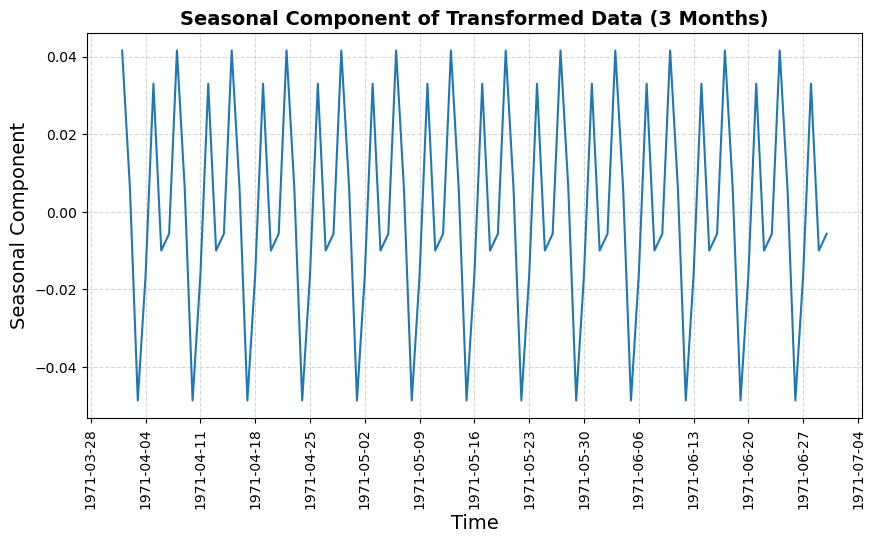

In [107]:
# Slice the dataframe for the desired period
df_period = df_decomposed.seasonal['1971-04-01':'1971-06-30']
# Create a figure
plt.figure(figsize= [10, 5])
# Plot the seasonal component
plt.plot(df_period)
# Add a title and axis labels
plt.title("Seasonal Component of Transformed Data (3 Months)", fontsize=14, fontweight="bold")
plt.xlabel("Time", fontsize=14, fontweight="normal", color="black")
plt.ylabel("Seasonal Component", fontsize=14, fontweight="normal", color="black")
# Format the x-axis to show dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# Set the x-axis ticks to occur every 7 days
# https://matplotlib.org/stable/api/dates_api.html#matplotlib.dates.DayLocator
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
# Enable grid lines
plt.grid(True, linestyle='--', alpha=0.5)
# Rotate x-axis labels
plt.xticks(rotation=90)
# Show the plot
plt.show()

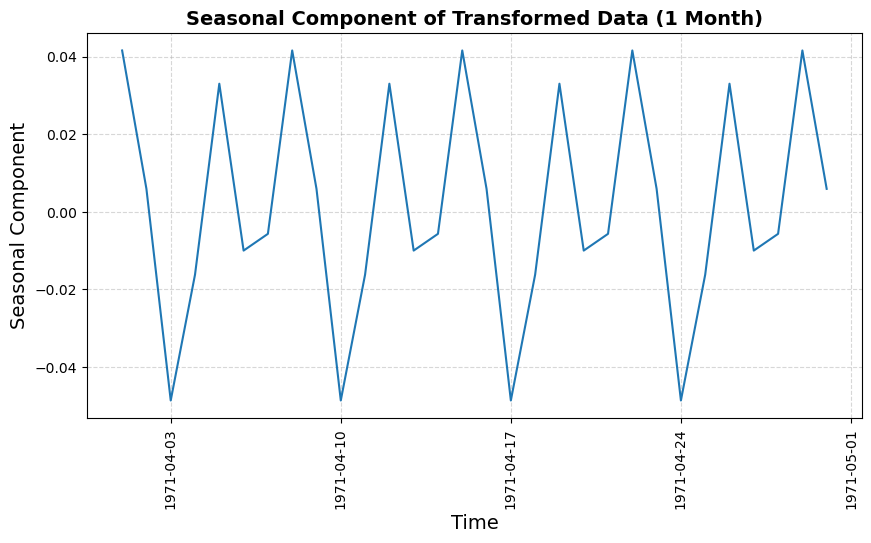

In [106]:
# Slice the dataframe for the desired period
df_period = df_decomposed.seasonal['1971-04-01':'1971-04-30']

# Create a figure
plt.figure(figsize= [10, 5])

# Plot the seasonal component
plt.plot(df_period)

# Add a title and axis labels
plt.title("Seasonal Component of Transformed Data (1 Month)", fontsize=14, fontweight="bold")
plt.xlabel("Time", fontsize=14, fontweight="normal", color="black")
plt.ylabel("Seasonal Component", fontsize=14, fontweight="normal", color="black")

# Format the x-axis to show dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set the x-axis ticks to occur every 7 days
# https://matplotlib.org/stable/api/dates_api.html#matplotlib.dates.DayLocator
# (matplotlib.dates — Matplotlib 3.8.1 Documentation, n.d.)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))

# Enable grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

### D1B. Trends

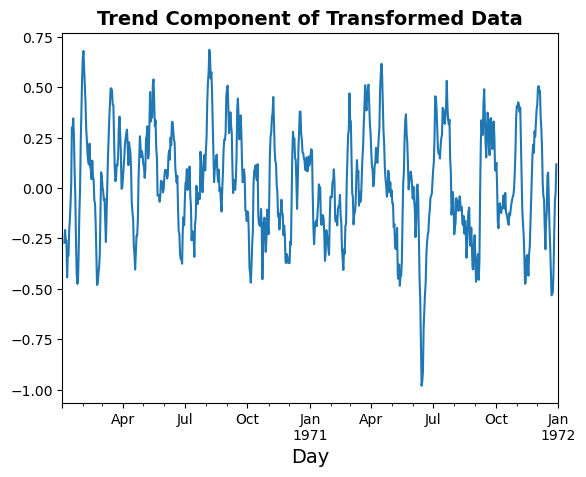

In [177]:
# duplicating. reusing df_decomposed from above
df_decomposed.trend.plot()
plt.title("Trend Component of Transformed Data", fontsize=14, fontweight="bold")
plt.xlabel("Day", fontsize=14, fontweight="normal", color="black")
plt.show()

### D1C. Autocorrelation

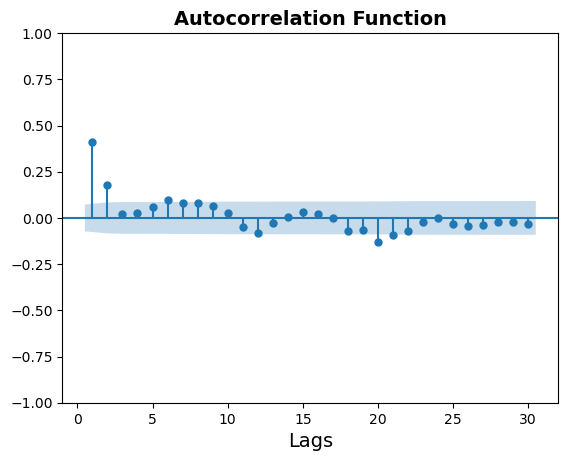

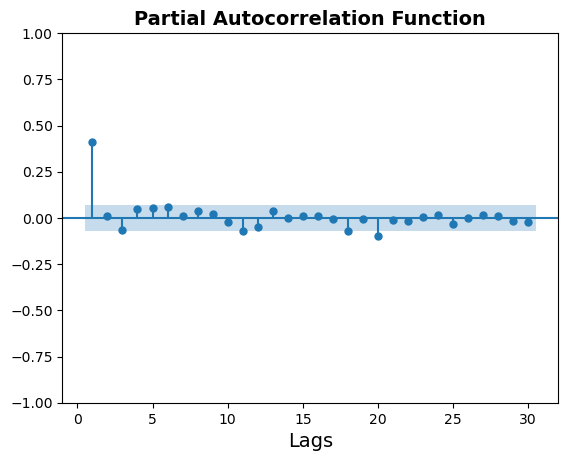

In [178]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF of training data
plot_acf(df_stationary, lags=30, zero=False)
plt.title('Autocorrelation Function', fontsize=14, fontweight="bold",)
plt.xlabel("Lags", fontsize=14, fontweight="normal", color="black")

# Plot the PACF of training data
plot_pacf(df_stationary, lags=30, zero=False)
plt.title('Partial Autocorrelation Function', fontsize=14, fontweight="bold",)
plt.xlabel("Lags", fontsize=14, fontweight="normal", color="black")

plt.show()

### D1D. Spectral Density

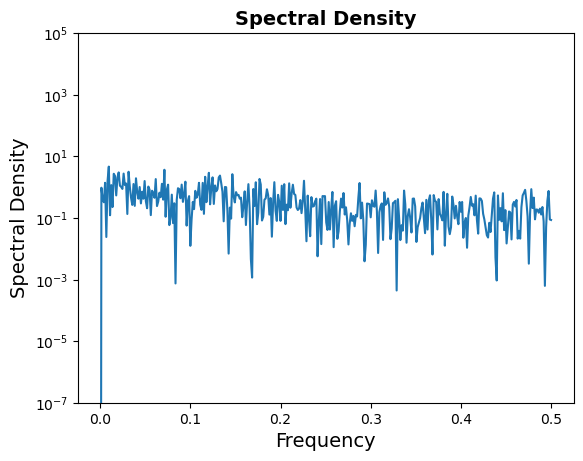

In [179]:
# from scipy import signal
# Compute the periodogram (spectral density)
f, Pxx_den = signal.periodogram(df_stationary['Revenue'])
# Plot the spectral density
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e5])
plt.title('Spectral Density', fontsize=14, fontweight="bold")
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Spectral Density', fontsize=14)
plt.show()


### D1E. Decomposed Time Series

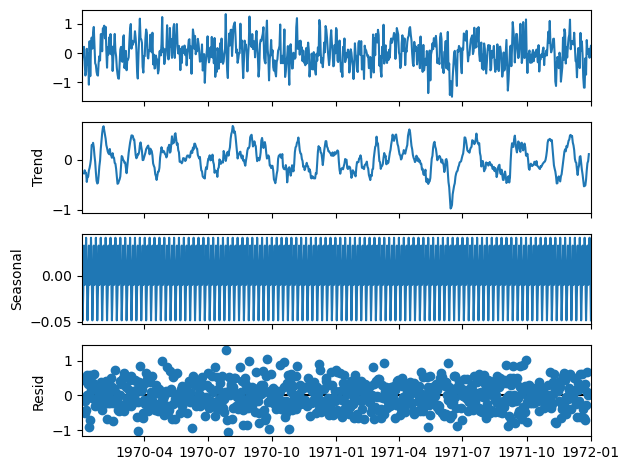

In [180]:
df_decomposed.plot();

### D1F. Confirmation of Lack of Trends

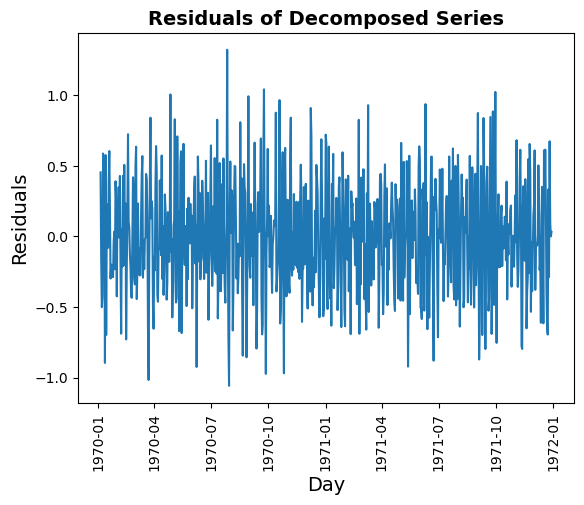

In [181]:
# Plot the seasonal component
plt.plot(df_decomposed.resid)

# Add a title and axis labels
plt.title("Residuals of Decomposed Series", fontsize=14, fontweight="bold")
plt.xlabel("Day", fontsize=14, fontweight="normal", color="black")
plt.ylabel("Residuals", fontsize=14, fontweight="normal", color="black")

# Rotate x-axis labels
plt.xticks(rotation=90)
# Show the plot
plt.show()

## D2 - ARIMA Model

### Auto-Arima Model

In [30]:
# Auto ARIMA on training
stepwise_fit = auto_arima(df_train['Revenue'], trace=True, suppress_warnings=True)
stepwise_fit.summary()
# look for smallest AIC. This is the best model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=705.799, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=811.077, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=706.698, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=729.446, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=811.809, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=704.445, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=702.940, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=704.368, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=708.264, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=705.851, Time=0.79 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=702.197, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=729.219, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=703.622, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=703.542, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=707.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  585
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -348.099
Date:                Thu, 16 Nov 2023   AIC                            702.197
Time:                        10:41:34   BIC                            715.307
Sample:                    01-01-1970   HQIC                           707.307
                         - 08-08-1971                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3930      0.040      9.788      0.000       0.314       0.472
ma.L2          0.2214      0.040      5.512      0.000       0.143       0.300
sigma2         0.1928      0.012     15.844      0.000       0.169       0.217
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.00
Prob(Q):                              0.89   Prob(JB):                         0.37
Heteroskedasticity (H):               1.05   Skew:                            -0.06
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### S/ARIMA/X model

In [133]:
initial_model = SARIMAX(df_train['Revenue'], order=(1,1,1))
initial_model_fit = initial_model.fit()
print(initial_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  585
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -350.669
Date:                Fri, 17 Nov 2023   AIC                            707.338
Time:                        21:05:08   BIC                            720.448
Sample:                    01-01-1970   HQIC                           712.448
                         - 08-08-1971                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4596      0.097      4.722      0.000       0.269       0.650
ma.L1         -0.0587      0.108     -0.545      0.586      -0.270       0.153
sigma2         0.1945      0.012     15.702      0.0

### Test model
0,0,0,7 gives AIC of 878.361 (pvalues 0). This is higher than not using the seasonal_order parameter
other order and seasonal order parameters tested here (in this part of code)

In [134]:
test_model = SARIMAX((df)['Revenue'], order=(1,1,1), seasonal_order=(0,0,0,7))
test_model_fit = test_model.fit()
print(test_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -437.964
Date:                Fri, 17 Nov 2023   AIC                            881.927
Time:                        21:06:49   BIC                            895.706
Sample:                    01-01-1970   HQIC                           887.243
                         - 01-01-1972                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4294      0.087      4.960      0.000       0.260       0.599
ma.L1         -0.0184      0.094     -0.196      0.845      -0.202       0.165
sigma2         0.1943      0.011     17.757      0.0

### Final Model

In [36]:
final_model = SARIMAX(df_train['Revenue'], order=(0,1,2))
final_model = final_model.fit()
print(final_model.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  585
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -348.099
Date:                Thu, 16 Nov 2023   AIC                            702.197
Time:                        10:46:13   BIC                            715.307
Sample:                    01-01-1970   HQIC                           707.307
                         - 08-08-1971                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3930      0.040      9.788      0.000       0.314       0.472
ma.L2          0.2214      0.040      5.512      0.000       0.143       0.300
sigma2         0.1928      0.012     15.844      0.0

## D3 - Predictions

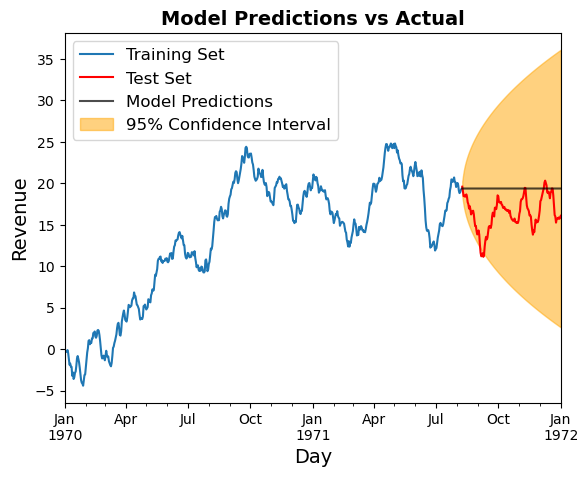

In [120]:
## Obtain predicted values and confidence intervals
start=len(df_train['Revenue'])
end=len(df_train['Revenue'])+len(df_test['Revenue'])-1
model_pred = final_model.get_prediction(start=start, end=end)
model_pred_95 = model_pred.conf_int()
ax = df_train['Revenue'].plot(label='Training Set')
ax = df_test['Revenue'].plot(label='Test Set', color='red')
model_pred.predicted_mean.plot(ax=ax, label='Model Predictions', alpha=.7, color='black')
ax.fill_between(model_pred_95.index,
                model_pred_95.iloc[:, 0],
                model_pred_95.iloc[:, 1], color='orange', alpha=.5, label="95% Confidence Interval")
plt.title('Model Predictions vs Actual', fontsize=14, fontweight="bold")
plt.xlabel('Day', fontsize=14)
plt.ylabel('Revenue', fontsize=14)
plt.legend(loc='upper left', fontsize = 12)
plt.show()

### Evaluation Metric - RMSE

#### Predicted Mean of Test Data

In [114]:
# predictions mean of test data
print(df_test['Revenue'].mean())

16.414766720547945


#### Root Mean Squared Error of Model and Test data

In [123]:
rmse = sqrt(mean_squared_error(pred, df_test['Revenue'])) # pred of final model
print(rmse)

3.5552104405812894


In [113]:
start=len(df_train)
end=len(df_train)+len(df_test)-1
pred=final_model.predict(start=start, end=end, typ='levels') 
print(pred)

1971-08-09    19.355621
1971-08-10    19.356796
1971-08-11    19.356796
1971-08-12    19.356796
1971-08-13    19.356796
                ...    
1971-12-28    19.356796
1971-12-29    19.356796
1971-12-30    19.356796
1971-12-31    19.356796
1972-01-01    19.356796
Freq: D, Name: predicted_mean, Length: 146, dtype: float64


### Model 2

In [40]:
model2=SARIMAX(df['Revenue'], order=(0,1,2))
model2 = model2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -436.181
Date:                Thu, 16 Nov 2023   AIC                            878.361
Time:                        10:47:22   BIC                            892.141
Sample:                    01-01-1970   HQIC                           883.678
                         - 01-01-1972                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4080      0.036     11.475      0.000       0.338       0.478
ma.L2          0.1978      0.036      5.452      0.000       0.127       0.269
sigma2         0.1934      0.011     17.889      0.0

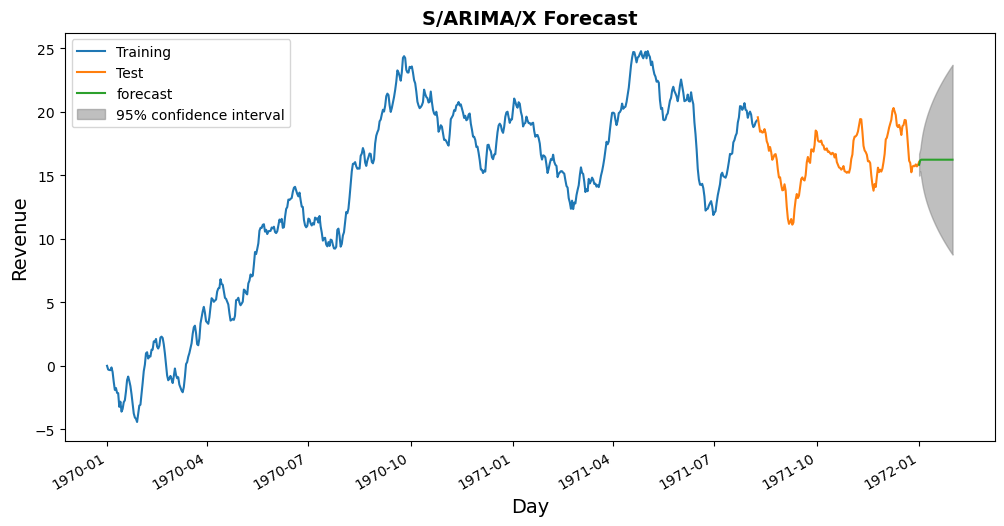

In [124]:
# get the last index of the data
last_index = df.index[-1]
# add 30 days to get the end index of the forecast
end_index = last_index + datetime.timedelta(days=30)
# Run model predictions
index_future_dates = pd.date_range(start='1972-01-01', end='1972-01-31')
# print(index_future_dates)
# Generate predictions for the next 30 days
pred = model2.predict(start=len(df_train)+len(df_test), end=len(df_train)+len(df_test)+30, typ='levels').rename('ARIMA Predictions')
# Assign the future dates to the prediction index
pred.index = index_future_dates
# print(pred)
# create a figure and axis object
fig, ax = plt.subplots(figsize=(12,6))
# plot the training data
ax.plot(df_train['Revenue'], label='Training')
# plot the test data
ax.plot(df_test['Revenue'], label='Test')
# use the plot_predict function with the model2 object and the same axis object
plot_predict(model2, start=last_index, end=end_index, alpha=0.05, ax=ax) # check if you want final_model or model2
# add the legend
ax.legend(loc='upper left')
# add the title
ax.set_title('S/ARIMA/X Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Day', fontsize=14)
plt.ylabel('Revenue', fontsize=14)
# show the figure
plt.show()

In [125]:
# print the predicted values
print(pred)

1972-01-01    16.192591
1972-01-02    16.236952
1972-01-03    16.236952
1972-01-04    16.236952
1972-01-05    16.236952
1972-01-06    16.236952
1972-01-07    16.236952
1972-01-08    16.236952
1972-01-09    16.236952
1972-01-10    16.236952
1972-01-11    16.236952
1972-01-12    16.236952
1972-01-13    16.236952
1972-01-14    16.236952
1972-01-15    16.236952
1972-01-16    16.236952
1972-01-17    16.236952
1972-01-18    16.236952
1972-01-19    16.236952
1972-01-20    16.236952
1972-01-21    16.236952
1972-01-22    16.236952
1972-01-23    16.236952
1972-01-24    16.236952
1972-01-25    16.236952
1972-01-26    16.236952
1972-01-27    16.236952
1972-01-28    16.236952
1972-01-29    16.236952
1972-01-30    16.236952
1972-01-31    16.236952
Freq: D, Name: ARIMA Predictions, dtype: float64


<Figure size 1200x600 with 0 Axes>

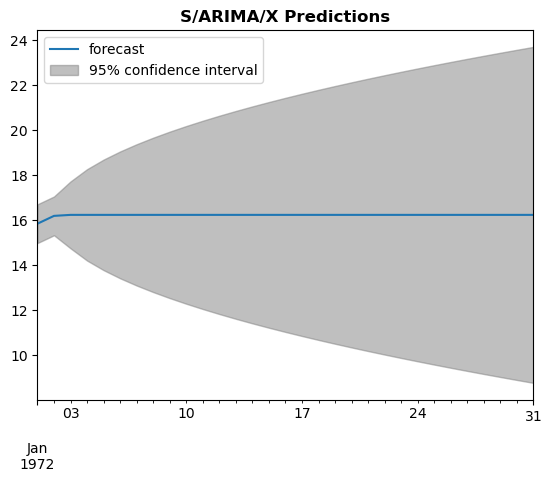

In [52]:
plt.figure(figsize=(12,6))
plot_predict(model2, start=last_index, end=end_index, alpha=0.05)
plt.legend(loc='upper left')
plt.title('S/ARIMA/X Predictions', fontweight='bold')
plt.show()

## D4: Output and Calculations
Additional Code that was used for this project include:
- Rolling Mean and Standard Deviation is located in C3
- Testing seasonal and order parameters is located in D2
- Code for the final model is located in D2
- Code for the model used for predictions is in section D3

# Part V: Data Summary and Implications
## E1: Results
- In this analysis, the SARIMAX class from the **statsmodels** library was used for time series forecasting. The SARIMAX model provides a robust and flexible framework for ARIMA modeling, as it includes an option to model the seasonal component of the time series, in addition to the standard ARIMA components. While the final model did not include a seasonal component, the use of the SARIMAX class allowed for the testing and exclusion of this component
### Selection of ARIMA model
- The selection of the SARIMAX model was based on several steps. First, an Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots were generated to identify potential orders for the AutoRegressive (AR) and Moving Average (MA) components of the model. Various combinations of these orders were tried and an **auto_arima** function to automate this process. The SARIMAX model that performed the best based on the Akaike Information Criterion (AIC) was an SARIMAX(0,1,2). This was also, the value identified by the auto_arima. The AIC is a measure used to compare different models, with a lower AIC indicating a better model fit (Gandhi, 2021). The SARIMAX(1,1,1) (identified in the reading of the PCF and ACF plots) had an AIC value of 707.338. Higher, than the SARIMAX(1,1,1) value of 702.197.
- The potential for seasonality in the data was explored by testing various seasonal orders in the SARIMAX model. However, none of these seasonal models provided a lower AIC than the SARIMAX(0,1,2) model. Thus, the final model did not include a seasonal component. Section D of this report, and the submitted code, have more details on model selection and results.
### Prediction Interval of Forecast
- Forecasting was performed using the SARIMAX(0,1,2) model at a daily interval. Given that the data consists of two years of daily revenue data, this granularity in our forecasts allows the capture of potential daily fluctuations in revenue.
- For the forecasts, a 95% prediction interval was used, which provides a range of likely values for the predictions. It's important to note that a prediction interval gives an estimated range of values which is likely to include an individual future point forecasted by the model, with a certain level of confidence.
- In assessing the accuracy of the model, the predictions for the test data (which was the last 20% of the original two years of data), was observed to fall within the prediction interval. This indicates that the model was able to accurately capture the variability in the data and provide a reasonable range for future predictions.
- When plotting the forecast, the predicted mean of the forecast values also fell within the prediction interval, providing further evidence of the model's ability to generate reasonable and reliable forecasts.
### Justification of Forecast Length
- The forecast length chosen was 30 days. Given two years of daily data, a forecast length of up to one year would be reasonable. However, a one-month forecast should be more accurate, and to forecast longer periods would require more historical data (Makridakis et al., 2008).
### Model Evaluation Procedure and Error Metric
- The model was evaluated based on the AIC and the p-values of the AR and MA components in the SARIMAX summary results. The model with the best AIC (702.197) and low p-values (below the alpha of 0.05) was selected.
- Additionally, the Root Mean Squared Error (RMSE) of the model's predictions was calculated against the actual values in the test set. The RMSE is a commonly used metric for evaluating the accuracy of a model's predictions, with a lower RMSE indicating more accurate predictions (Jie, 2022). Our final model achieved an RMSE of 3.55521, which given the mean of the test data (16.4148), indicates that the model's forecasts are reasonably accurate.
- The code and output for the RMSE can be found in Section D3 (Code, Calculations, Output for Parts II - IV); above.

## E2: Annotated Visualization
- The annotated visualizations for the final model compared to the test are displayed in section D3 - Model 2 (Code, Calculations, Output for Parts II - IV), above.

## E3: Recommendation
- The results of this analysis demonstrate that the SARIMAX model, specifically a SARIMAX(0,1,2), can be effectively used to forecast the next month of revenue for a healthcare organization based on the first two years of daily revenue data. The model demonstrated a good performance accuracy in forecasting 30 days of future revenue, and the predictions for the test data fell within the prediction interval, validating the model's performance.
- While the model performed well with two years of data, the accuracy of the predictions could potentially be improved with more data and data points. Therefore, the recommendation is that the healthcare organization continue to collect and analyze daily revenue data to further refine and improve the accuracy of the model over time.
- It's also important to note that the time period of the days covered in the data was not specified. Knowing the exact years, the days were from would make the analysis more meaningful, especially when comparing to the present and forecasting for the future. Thus, another recommendation would be that the organization also collect and include this information in future analyses.
- In summary, the SARIMAX model provides a robust and effective tool for forecasting future revenue for the healthcare organization. The recommendation is for continued data collection and refinement. With this, the tool can support strategic planning and decision-making within the organization

# Part VI: Reporting
- See the written report, in Word, for references.